# Metagenomics

### Prerequisites

- keras
- scikit-learn

In [1]:
import re
import numpy as np

## 0. Introduction

Metagenomics is the study of an environment from the genomic material it contains.

An important problem in metagenomics is **binning**, assigning fragments to taxonomic clades. Current sequencing technologies output millions of short DNA fragments (reads) in random order. 

There are 2 different types of approaches to this problem:
 - **aligment**-based approaches try to align the reads to reference genomes using string methods
 - **compositional** approaches view binning as a classification problem
 
In this notebook we will concentrate on the second type, and use machine learning to classify fragments of microbial DNA

## 1. Data

The data is composed of a training set and a validation set.
- The training set is 10 full bacterial genomes and their taxonomic ids (the classification label). Each genome belongs to a different species, so there are 10 labels in all.
- The validation set is composed of 10000 fragments of length 100bp, drawn from the genomes in the training set.

In [2]:
# train
train_path = 'data/train'
train_sequences_path = '{}/train_sequences.txt'.format(train_path)
train_labels_path = '{}/train_labels.txt'.format(train_path)
# test
test_path = 'data/test'
test_sequences_path = '{}/test_sequences.txt'.format(test_path)
test_labels_path = '{}/test_labels.txt'.format(test_path)

X_train_full = np.loadtxt(train_sequences_path, dtype=str)
X_test_frag = np.loadtxt(test_sequences_path, dtype=str)

y_train_full = np.loadtxt(train_labels_path, dtype=str)
y_test = np.loadtxt(test_labels_path, dtype=str)

In [3]:
print('Train sequences')
print('---------------')
for seq, h in zip(X_train_full, y_train_full):
    print('Label: {}'.format(h))
    print('Length: {}'.format(len(seq)))
    print('Sequence beginning: {}...'.format(seq[:20]))
    print('---')

Train sequences
---------------
Label: 234267
Length: 9965640
Sequence beginning: CAAATCTACCTGAACATCAG...
---
Label: 240015
Length: 4127356
Sequence beginning: GTCCCATGGAATCAATAGCT...
---
Label: 755732
Length: 4633577
Sequence beginning: TATTAACATATTATTTACAA...
---
Label: 1193806
Length: 1452335
Sequence beginning: ACAACTTTATTTTAATTTAT...
---
Label: 755178
Length: 4114099
Sequence beginning: ATTAATAAGAGTTTAAACAA...
---
Label: 1100841
Length: 3957364
Sequence beginning: CCGACTCAGTGTCGGACTTT...
---
Label: 1274814
Length: 4798433
Sequence beginning: ATTGGCGCAGAAAAAAATGC...
---
Label: 229193
Length: 4595065
Sequence beginning: TCGCGCGATCTTTGAGCTAA...
---
Label: 395491
Length: 4767043
Sequence beginning: TGATCGGGCGGCCGTTTTAG...
---
Label: 481448
Length: 2287145
Sequence beginning: AAATATTTATTTTTTAAGAT...
---


### Extracting fragments

In order to train the classification model, we feed it training samples with their corresponding labels. To generate these training samples, we draw random fragments from the full training genomes.

The **coverage** is the average number of times each nucleotide (letter 'A', 'C', 'G', 'T') is covered. For fragments of length 100, and a 1M-long genome, a coverage of 1 corresponds to $1M / 100 = 10000$ fragments. 

In [4]:
def fragment_generator(sequence, length=100):
    '''
    Generates random substrings of length `length` from string `sequence`
    '''
    full_length = len(sequence)
    while True:
        i = np.random.randint(0, full_length-length)
        yield sequence[i:i+length]

    
def draw_fragments(sequence, coverage=1, length=100):
    '''
    Draws random fragments from `sequence`, such that each character is covered
    `coverage` times on average
    '''
    n_frags = int(len(sequence) * coverage) // length
    gen = fragment_generator(sequence, length=length)
    return [gen.next() for _ in range(n_frags)]
    

def draw_fragments_labelled(sequences, labels, coverage=1, length=100, shuffle=True):
    '''
    Draws random fragments from `sequences`, such that each character is covered
    `coverage` times on average
    '''
    fragments = []
    frag_labels = []
    for seq, label in zip(sequences, labels):
        frags = draw_fragments(seq, coverage=coverage, length=length)
        fragments += frags
        frag_labels += [label]*len(frags)
    fragments, frag_labels = np.array(fragments), np.array(frag_labels)
    if shuffle:
        p = np.random.permutation(len(fragments))
        return fragments[p], frag_labels[p]
    return fragments, frag_labels

In [5]:
X_train_frag, y_train_frag = draw_fragments_labelled(X_train_full, y_train_full, coverage=1)

In [6]:
print('Sample reads')
for X, y in zip(X_train_frag[:3], y_train_frag[:3]):
    print('Label {}, Read {}'.format(y, X))

Sample reads
Label 755178, Read AGATTTACTGTTTGCTTTAGGTCCGGCTATTCATGGTAAGGTATATCAAGTCAATGAAGAAGTTGCCGTCGAGGTTTTAAAAACTATTTTCCCTTCAGAT
Label 395491, Read TCGTCGTCATGGCGATCAACGCCTGGAACCGCGTCAATGTCGGCTTCAAGACCGTGCCCGGCACGGCCGACAAGGCCTACGGCCTCGATAAGGCTGGCCT
Label 240015, Read AACTGCAGCATCACCGGATGCTTCCCTGCCCGCAACAAAGAGTAATGCCGCCGCATGCGGCTCTCGCTCGCCTGCAACGGCGTGCGTGCCGCTTCGCCAA


## 2. Linear models

### 2. a) k-mer representation
A standard method in machine learning approaches to metagenomics is to represent a DNA sequence as the sum of its short subsequences (**k-mers**). 

**Example:** The sequence `'AATACGGAA'` can be represented by the list of its 3-mers `['AAT', 'ATA', 'TAC', 'ACG', 'CGG', 'GGA', 'GAA']`

The k-mer representation is then one hot encoded, so that a DNA sequence becomes a vector in $\mathbb{R}^K$ where $K$ is the vocabulary size. For short k-mers (small values of $k$), $K = 4^k$. 

This is similar to the **Bag-of-Words** representation in NLP.

#### Implementation
The `CountVectorizer` class from scikit-learn can be used to implement this.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

def KmerVectorizer(k=3):
    '''
    Returns a Vectorizer that transforms a sequence into a vector of the counts of its k-mers
    '''
    return CountVectorizer(analyzer='char', ngram_range=(k, k), dtype=np.int8)

vectorizer = KmerVectorizer(k=3)

# Should take less than a minute
%time vectorizer.fit(X_train_full)

CPU times: user 27.8 s, sys: 1.39 s, total: 29.2 s
Wall time: 28.9 s


CountVectorizer(analyzer='char', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int8'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(3, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [8]:
len(vectorizer.vocabulary_)

64

In [9]:
%%time 
X_train_kmer = vectorizer.transform(X_train_frag)
X_test_kmer = vectorizer.transform(X_test_frag)

CPU times: user 33.6 s, sys: 1.17 s, total: 34.8 s
Wall time: 34.2 s


In [10]:
X_train_kmer

<446975x64 sparse matrix of type '<type 'numpy.int8'>'
	with 20552934 stored elements in Compressed Sparse Row format>

### 2. b) Learning a linear classifier

#### Training

In [11]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

# This can take a couple of minutes
%time logreg.fit(X_train_kmer, y_train_frag)

CPU times: user 1min 41s, sys: 459 ms, total: 1min 41s
Wall time: 1min 42s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Evaluation

As an example evaluation metric, the average species-level precision and recall are used below.

In [12]:
from sklearn.metrics import accuracy_score

def precision_recall(y_pred, y_true):
    rec_per_species = [accuracy_score(y_pred[y_true==k], y_true[y_true==k])
                       for k in np.unique(y_true)]
    rec = np.mean(rec_per_species)
    acc_per_species = [accuracy_score(y_pred[y_pred==k], y_true[y_pred==k])
                       for k in np.unique(y_true) if (y_pred==k).any()]
    prec = np.mean(acc_per_species)
    
    print('''Recall: {:.2%}  Precision: {:.2%}'''.format(rec, prec))

In [13]:
%time y_pred = logreg.predict(X_test_kmer)
print('----------------------')
print('Validation performance')
precision_recall(y_pred, y_test)

CPU times: user 6.26 ms, sys: 3.93 ms, total: 10.2 ms
Wall time: 8.45 ms
----------------------
Validation performance
Recall: 46.07%  Precision: 49.69%


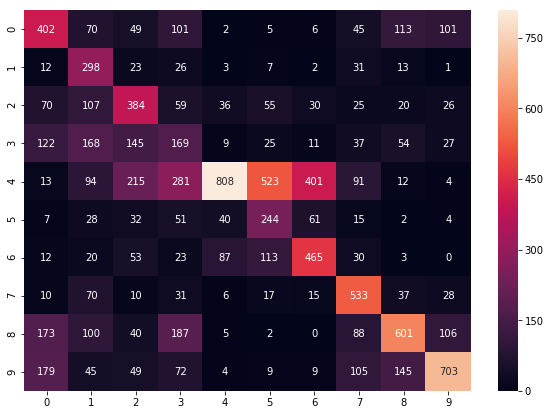

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion(y_pred, y_test):
    plt.figure(figsize = (10,7))
    sn.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='d')
    plt.show()
    
plot_confusion(y_pred, y_test)

### 2. c) Going further

Default values of $k$ are small ($k \in [3, 6] $) to keep training times and memory footprints manageable. Optimal performance is obtained for greater values ($k \geq 12$), which are discouraged in this setting.

Feel free to vary values of coverage, k-mer length, as well as parameters of the `LogisticRegression`, or even trying other models altogether.

## 3. Convolutional neural networks (CNN)

In the past few years, "deep" learning methods have been applied with some success to problems in genomics.

As CNNs have enjoyed great success in NLP problems, we try them out here.

### 3. a) Preprocessing

#### Vectorizing the input

`tensorflow` and `keras` only accept vectors of floats inputs, so the text sequences must be translated to vectors. We do so by one hot encoding on both the input sequences and the labels.

In [15]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
y_train_binary = label_binarizer.fit_transform(y_train_full)
y_test_binary = label_binarizer.transform(y_test)

In [16]:
def seq2img(s):
    '''
    Transforms a sequence of n letters ACGT to a n*4 binary vector
    Discards letters that are not ACGT
    '''
    s = re.sub('[^ACGT]', '', s)
    base2int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    img = np.zeros((len(s), 4), dtype=bool)
    non_acgt_count = 0
    for i, a in enumerate(s):
        img[i, base2int[a]] = True
    return img

X_train_binary = [seq2img(seq) for seq in X_train_full]
X_test_binary = [seq2img(seq) for seq in X_test_frag]

#### Generating fragments
Instead of first generating fragments and then training a model, as we did for the scikit-learn models, we can make use of `keras`'s `fit_generator` function to generate fragments on the fly while training. This is much more memory-efficient.  

In [17]:
def frag_generator(X, y, frag_length=100, batch_size=1):
    '''
    Generates batches of randomly drawn fragments from the sequences `X`
    
    Attributes
    ----------
    X: list (nsamples)
        Sequences from which to extract fragments
    y: array (nsamples, nlabels)
        Sequence labels
    length: int
        Length of the extracted fragments
    batch_size: int
        Number of fragments yielded
    '''
    seq_lengths = [seq.shape[0] for seq in X]
    n_samples = len(X)
    n_labels = y.shape[1]

    # p are the probabilities for each sequence to be chosen
    p = np.array(seq_lengths).astype('float')
    p /= p.sum()
    while True:
        X_batch = np.zeros((batch_size, frag_length, 4))
        y_batch = np.zeros((batch_size, n_labels))

        # Choose sequences such that coverage is uniform
        seq_indices = np.random.choice(range(n_samples), batch_size, p=p)

        for i, seq_ix in enumerate(seq_indices):
            # Choose random position in the sequence
            pos = np.random.randint(seq_lengths[seq_ix] - frag_length)
            X_batch[i, :, :] = X[seq_ix][pos:pos + frag_length]
            y_batch[i] = y[seq_ix]

        yield X_batch, y_batch

In [18]:
# Data parameters
n_species = y_train_binary.shape[1]
frag_length = 100

### 3. b) Defining and training the model

In [19]:
def fit(model, X, y,
        model_name='default_model',
        frag_length=100,
        batch_size=32,
        coverage=1,
        epochs=10):
    '''
    Fits `model` and saves and best weights
    '''
    filepath = "models/{}.h5".format(model_name)
    
    total_length = sum(len(seq) for seq in X)
    steps_per_epoch = (coverage * total_length) // (batch_size * frag_length * epochs)
    
    # Saves model weights at the end of the epoch if train accuracy is better
    checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1,
                                 save_best_only=True, mode='max')

    history_callback = model.fit_generator(
        generator=frag_generator(X, y, batch_size=batch_size, frag_length=frag_length),
        workers=4, use_multiprocessing=True,
        callbacks=[checkpoint],
        steps_per_epoch=steps_per_epoch, epochs=epochs
        )
    loss_history = history_callback.history["loss"]
    return loss_history

In [20]:
# Silence tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Dense, Flatten
from keras.layers.normalization import BatchNormalization

# ----------------------------------
# Define model
# ----------------------------------

# If set to False, freeze convolution weights,
# or keep them as initialized
retrain_conv = True

model = Sequential()
n_filters = 64
filter_size = 5

layers = [
    Conv1D(n_filters, filter_size, padding='same', activation='relu',
           trainable=retrain_conv, name='conv_1', input_shape=(frag_length, 4)),
    # MaxPooling1D(pool_size=2, name='maxp_1'),
    # Conv1D(n_filters*2, filter_size, padding='same', activation='relu',
    #       trainable=retrain_conv, name='conv_2'),
    # BatchNormalization(),
    GlobalAveragePooling1D(),
    Dense(n_species, activation='softmax'),
    ]
    
for l in layers:
    model.add(l)
    
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print model.count_params()

/Users/romainmenegaux/Dev/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1994


In [21]:
loss_history = fit(model, X_train_binary, y_train_binary, coverage=1, epochs=5)

/Users/romainmenegaux/Dev/miniconda2/lib/python2.7/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
2793/2793 [==============================] - 12s - loss: 1.6674 - acc: 0.3571    
Epoch 2/5
2793/2793 [==============================] - 11s - loss: 1.5504 - acc: 0.4037    
Epoch 3/5
2793/2793 [==============================] - 11s - loss: 1.4776 - acc: 0.4364    
Epoch 4/5
2793/2793 [==============================] - 11s - loss: 1.4193 - acc: 0.4621    
Epoch 5/5
2793/2793 [==============================] - 11s - loss: 1.3673 - acc: 0.4865    


In [22]:
%time y_pred = model.predict(np.array(X_test_binary))
y_pred = label_binarizer.inverse_transform(y_pred)
print('----------------------')
print('Validation performance')
precision_recall(y_pred, y_test)

CPU times: user 754 ms, sys: 48.1 ms, total: 802 ms
Wall time: 327 ms
----------------------
Validation performance
Recall: 39.64%  Precision: 42.55%


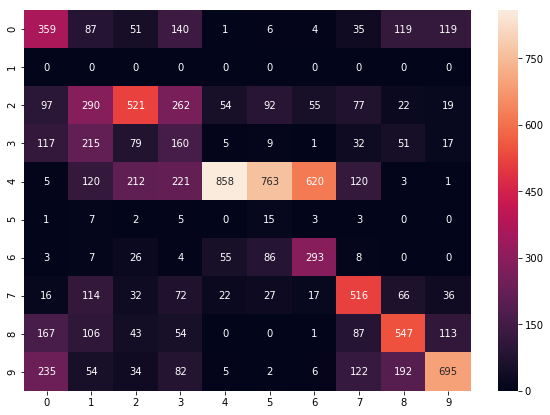

In [23]:
plot_confusion(y_pred, y_test)

### 2. c) Going further

Try changing filter sizes, number of filters or adding/changing layers.

## Recurrent neural networks

Implement a simple RNN to try and match previous performances.

In [24]:
from keras.layers import LSTM



